In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pymc.sampling_jax
import numpy as np
import scipy as sp
import aesara
import lifelines

/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Load data

In [2]:
data = pd.read_csv("../data/veteran.csv")

In [3]:
data

,time,status,karno,diagtime,age,prior,trt,celltype
0,72,1,60,7,69,0,1,1
1,411,1,70,5,64,10,1,1
2,228,1,60,3,38,0,1,1
3,126,1,60,9,63,10,1,1
4,118,1,70,11,65,10,1,1
...,...,...,...,...,...,...,...,...
132,133,1,75,1,65,0,2,4
133,111,1,60,5,64,0,2,4
134,231,1,70,18,67,10,2,4
135,378,1,80,4,65,0,2,4


In [4]:
X = data[['age', 'trt']].copy()
X['celltype_1'] = data['celltype'] == 1
X['celltype_2'] = data['celltype'] == 2
X['celltype_3'] = data['celltype'] == 3
X['celltype_4'] = data['celltype'] == 4
X['prior'] = data['prior'] == 10
X['karno'] = data['karno']
X['trt'] = data['trt'] == 2
X['diagtime'] = data['diagtime']

y = data[['time', 'status']].values
y[:, 1] = 1 - y[:, 1]  # inverse

# X_train = X.values.astype(float)
# y_train = 1 - y[:, 1].astype(float)

n_predictors = X.shape[1]

# print(X_train.shape)
# print(y_train.shape)

In [23]:
with pm.Model() as model:
    ell = pm.InverseGamma("ell", mu=1.0, sigma=0.5, shape=(n_predictors,))
    eta = pm.Exponential("eta", lam=1.0)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(input_dim=n_predictors, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_train)

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    # lambda_det = pm.Deterministic("lambda_det", pm.math.exp(f))
    y_ = pm.Bernoulli("y", p=p, observed=y_train)

    # censor_ = at.eq(censor_, 1)
    # y = pm.Exponential("y", at.ones_like(time_uncensor_) / lambda_det[~censor_],
    #                    observed=time_uncensor_)
    #
    # def exponential_lccdf(lam, time):
    #     """ Log complementary cdf of Exponential distribution. """
    #     return -(lam * time)
    #
    # y_cens = pm.Potential(
    #     "y_cens", exponential_lccdf(at.ones_like(time_censor_) / lambda_det[censor_], time_censor_)
    # )

    trace = pm.sample(draws=1000, tune=500, chains=2, random_seed=1, cores=1, progressbar=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc:Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, f_rotated_]
INFO:pymc:NUTS: [ell, eta, f_rotated_]


Sampling 2 chains for 50 tune and 100 draw iterations (100 + 200 draws total) took 174 seconds.
INFO:pymc:Sampling 2 chains for 50 tune and 100 draw iterations (100 + 200 draws total) took 174 seconds.


array([[<AxesSubplot: title={'center': 'f_rotated_'}>,
        <AxesSubplot: title={'center': 'f_rotated_'}>],
       [<AxesSubplot: title={'center': 'ell'}>,
        <AxesSubplot: title={'center': 'ell'}>],
       [<AxesSubplot: title={'center': 'eta'}>,
        <AxesSubplot: title={'center': 'eta'}>],
       [<AxesSubplot: title={'center': 'f'}>,
        <AxesSubplot: title={'center': 'f'}>],
       [<AxesSubplot: title={'center': 'p'}>,
        <AxesSubplot: title={'center': 'p'}>]], dtype=object)

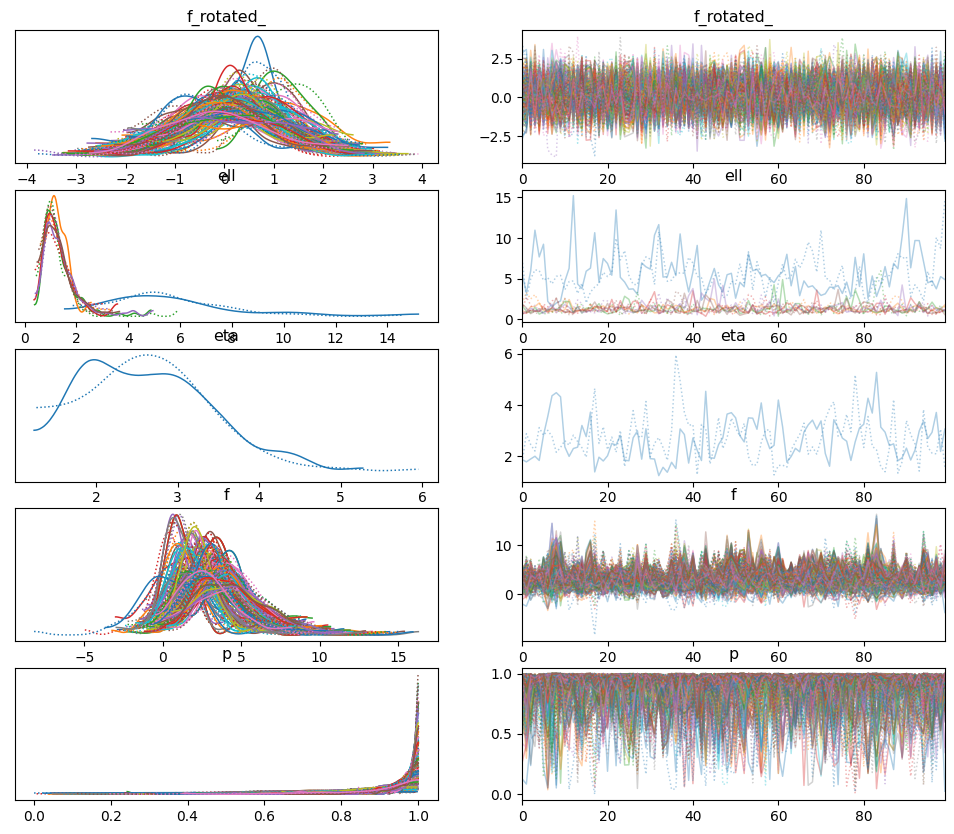

In [24]:
az.plot_trace(trace);

In [94]:
y_train = y[:, 0].astype(float)

with pm.Model() as model2:
    ell = pm.InverseGamma("ell", mu=1.0, sigma=0.5, shape=(n_predictors,))
    eta = pm.Exponential("eta", lam=1.0)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(input_dim=n_predictors, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_train)

    # logit link and Bernoulli likelihood
    # p = pm.Deterministic("p", pm.math.invlogit(f))
    
    lambda_intercept = pm.Normal("lambda_intercept",
                                 mu=0, 
                                 sigma=1)
    
    lambda_det = pm.Deterministic("lambda_det", pm.math.exp(lambda_intercept + f))
    # y_ = pm.Bernoulli("y", p=p, observed=y_train)

    # censor_ = at.eq(censor_, 1)
    # without censoring
    y_ = pm.Exponential("y", pm.math.ones_like(y_train) / lambda_det, observed=y_train)
    #
    # def exponential_lccdf(lam, time):
    #     """ Log complementary cdf of Exponential distribution. """
    #     return -(lam * time)
    #
    # y_cens = pm.Potential(
    #     "y_cens", exponential_lccdf(at.ones_like(time_censor_) / lambda_det[censor_], time_censor_)
    # )

    trace2 = pm.sampling_jax.sample_numpyro_nuts(draws=1000, tune=500, chains=2, random_seed=1, progress_bar=True)

Compiling...
Compilation time =  0:00:01.232539
Sampling...


Running chain 1: 100%|██████████| 1500/1500 [02:07<00:00, 11.76it/s]


Sampling time =  0:02:07.831258
Transforming variables...
Transformation time =  0:00:04.932205
Computing Log Likelihood...
Log Likelihood time =  0:00:04.280737


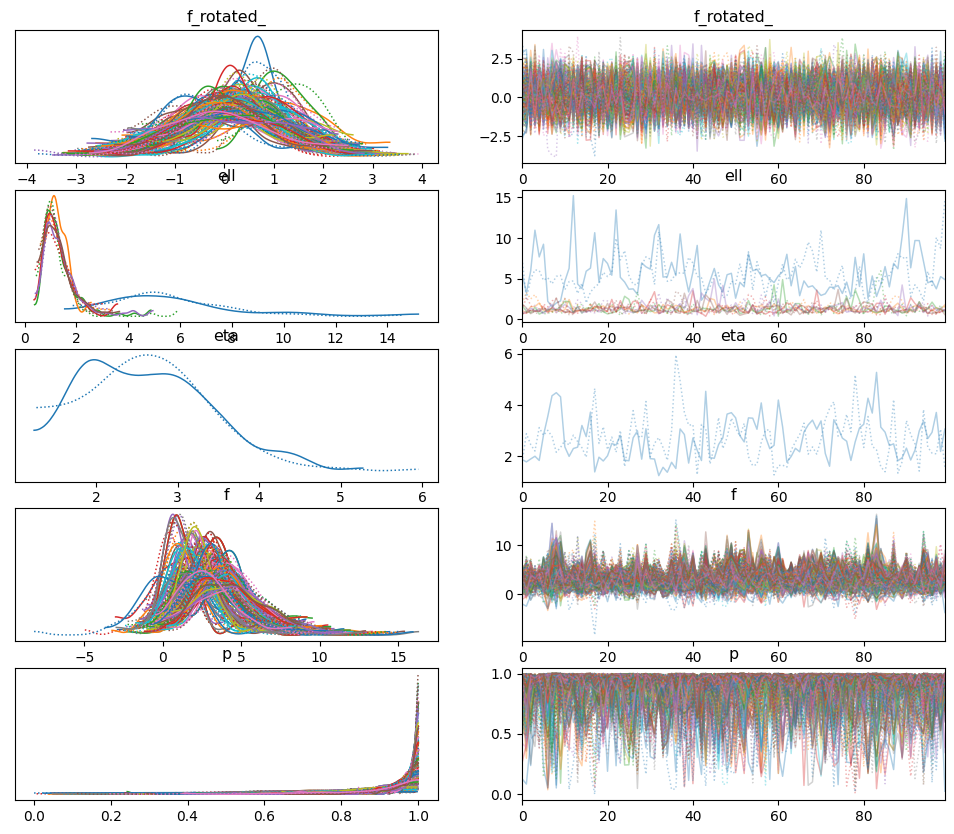

In [95]:
az.plot_trace(trace);

In [96]:
with model2:
    ppc = pm.sample_posterior_predictive(trace2, var_names=['y', 'lambda_det'], return_inferencedata=False)
    print(ppc.keys())

Sampling: [y]
INFO:pymc:Sampling: [y]


dict_keys(['y', 'lambda_det'])


In [97]:
lambda_det = ppc['lambda_det'].reshape(-1, 137).mean(axis=0)
print(lambda_det.shape)
print(y_train.shape)


(137,)
(137,)


In [98]:
pymc.__version__

'4.3.0'

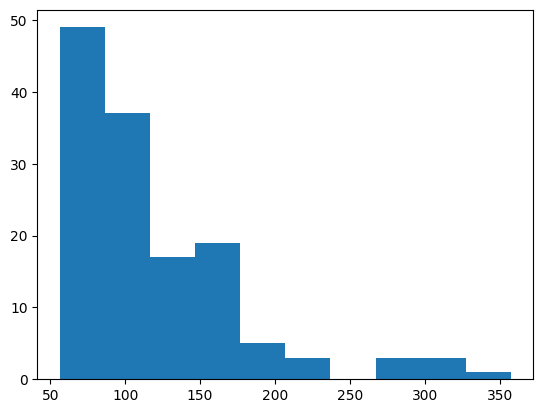

In [99]:
plt.hist(lambda_det);

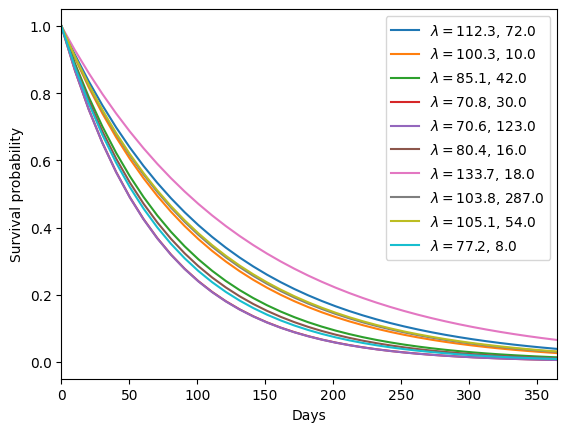

In [93]:
t = np.linspace(0, max(y_train), 100)

S0 = sp.stats.expon.sf

for i in range(10):
    sample_lambda = lambda_det[i*5]
    y_true = y_train[i*5]
    plt.plot(t, S0(t / sample_lambda), label = f"$\lambda={round(sample_lambda, 1)}$, {y_true}");
    
plt.ylabel("Survival probability")
plt.xlabel("Days")
# plt.title("Effect of $\kappa$")
plt.legend();
plt.xlim(0, 365);


In [121]:
y_train = y.astype(float)
print(y_train.shape)

with pm.Model() as model2:
    ell = pm.InverseGamma("ell", mu=1.0, sigma=0.5, shape=(n_predictors,))
    eta = pm.Exponential("eta", lam=1.0)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(input_dim=n_predictors, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_train)

    # logit link and Bernoulli likelihood
    # p = pm.Deterministic("p", pm.math.invlogit(f))
    
    lambda_intercept = pm.Normal("lambda_intercept",
                                 mu=0, 
                                 sigma=1)
    
    lambda_det = pm.Deterministic("lambda_det", pm.math.exp(lambda_intercept + f))
    # y_ = pm.Bernoulli("y", p=p, observed=y_train)

    # censor_ = pm.math.eq(y_train[:, 1], 1)
    # print(y_train[:, 0].eval())
    # without censoring
    y_ = pm.Exponential("y", pm.math.ones_like(y_train[y_train[:, 1] == 0, 0]) / lambda_det[y_train[:, 1] == 0], 
                        observed=y_train[y_train[:, 1] == 0, 0])
    
    def exponential_lccdf(lam, time):
        """ Log complementary cdf of Exponential distribution. """
        return -(lam * time)
    
    y_cens = pm.Potential(
        "y_cens", exponential_lccdf(pm.math.ones_like(y_train[y_train[:, 1] == 1, 0]) / lambda_det[y_train[:, 1] == 1], 
                                    y_train[y_train[:, 1] == 1, 0])
    )

    trace2 = pm.sampling_jax.sample_blackjax_nuts(draws=1000, tune=500, chains=2, random_seed=1)

(137, 2)
Compiling...
Compilation time =  0:00:06.073041
Sampling...
Sampling time =  0:00:10.644499
Transforming variables...
Transformation time =  0:02:18.783335
Computing Log Likelihood...
Log Likelihood time =  0:00:11.483838


In [123]:
with model2:
    ppc = pm.sample_posterior_predictive(trace2, var_names=['y', 'lambda_det'], return_inferencedata=False)
    print(ppc.keys())
    
lambda_det = ppc['lambda_det'].reshape(-1, 137).mean(axis=0)


/tmp/ipykernel_33/3015643419.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace2, var_names=['y', 'lambda_det'], return_inferencedata=False)
Sampling: [y]
INFO:pymc:Sampling: [y]


dict_keys(['y', 'lambda_det'])


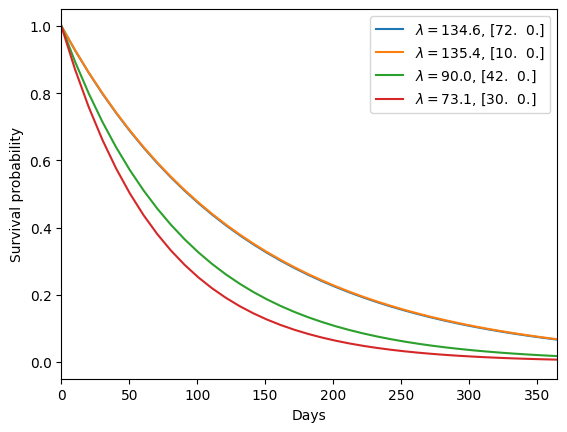

In [124]:
t = np.linspace(0, max(y_train[:,0]), 100)

S0 = sp.stats.expon.sf

for i in range(4):
    sample_lambda = lambda_det[i*5]
    y_true = y_train[i*5]
    plt.plot(t, S0(t / sample_lambda), label = f"$\lambda={round(sample_lambda, 1)}$, {y_true}");
    
plt.ylabel("Survival probability")
plt.xlabel("Days")
# plt.title("Effect of $\kappa$")
plt.legend();
plt.xlim(0, 365);


# Best model

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values.astype(float)
y_train = y_train.astype(float)
X_test = X_test.values.astype(float)
y_test = y_test.astype(float)

In [7]:
X_test.shape

(28, 9)

In [95]:
# y_train = y.astype(float)
# print(y_train.shape)

with pm.Model() as model3:
    model_input = pm.MutableData("model_input", X_train)
    
    ell = pm.InverseGamma("ell", mu=1.0, sigma=0.5, shape=(n_predictors,))
    eta = pm.Exponential("eta", lam=1.0)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(input_dim=n_predictors, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=model_input)
    
    lambda_intercept = pm.Normal("lambda_intercept",
                                 mu=0, 
                                 sigma=1)
    
    lambda_det = pm.Deterministic("lambda_det", pm.math.exp(f))
    
    y_ = pm.Exponential("y", pm.math.ones_like(y_train[y_train[:, 1] == 0, 0]) / lambda_det[y_train[:, 1] == 0], 
                        observed=y_train[y_train[:, 1] == 0, 0])
    
    def exponential_lccdf(lam, time):
        """ Log complementary cdf of Exponential distribution. """
        return -(lam * time)
    
    y_cens = pm.Potential(
        "y_cens", exponential_lccdf(pm.math.ones_like(y_train[y_train[:, 1] == 1, 0]) / lambda_det[y_train[:, 1] == 1], 
                                    y_train[y_train[:, 1] == 1, 0])
    )
    
    # f_pred = gp.conditional("f_pred", model_input, jitter=1e-4)
    # p_pred = pm.Deterministic("lambda_det_pred", pm.math.exp(lambda_intercept + f_pred))

    trace3 = pm.sampling_jax.sample_numpyro_nuts(draws=1000, tune=500, chains=2, random_seed=1)
    
az.to_netcdf(trace3, filename='saved_numpyro.netcdf')

Compiling...
Compilation time =  0:00:02.155292
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:04:58.966161
Transforming variables...
Transformation time =  0:00:02.372750
Computing Log Likelihood...
Log Likelihood time =  0:00:02.701090


'saved_numpyro.netcdf'

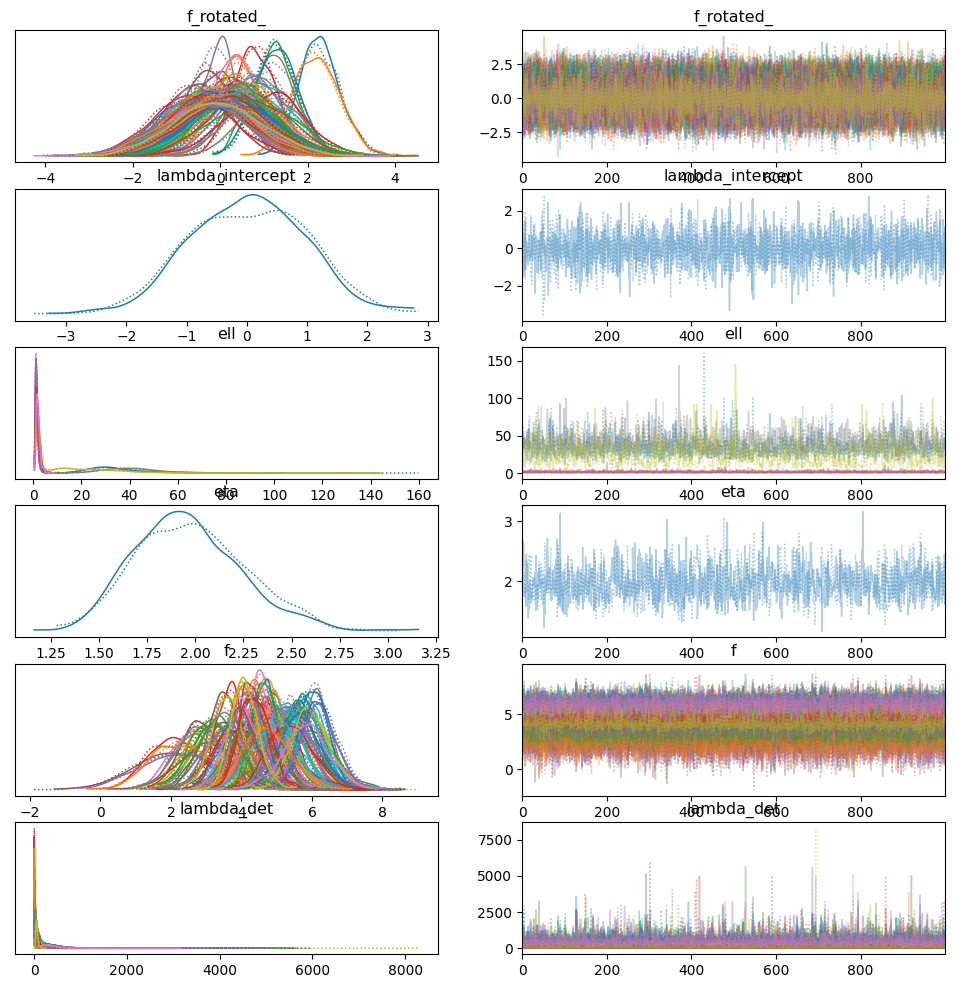

In [96]:
az.plot_trace(trace3);

In [97]:
n_nonconverged = int(np.sum(az.rhat(trace3)[["eta", "ell", "f_rotated_"]].to_array() > 1.03).values)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")


No Rhat values above 1.03, ✓


In [98]:
with model3:
    f_pred = gp.conditional("f_pred", X_test, jitter=1e-4)
    p_pred = pm.Deterministic("lambda_det_pred", pm.math.exp(lambda_intercept + f_pred))


In [99]:

# thinned_idata = trace3.sel(draw=slice(None, None, 1))

with model3:
    ppc = pm.sample_posterior_predictive(trace3, var_names=["f_pred", "lambda_det_pred"], return_inferencedata=False, random_seed=0)

print(ppc.keys(), ppc['lambda_det_pred'].shape)
lambda_det = ppc['lambda_det_pred'].reshape(-1, ppc['lambda_det_pred'].shape[2]).mean(axis=0)
print(lambda_det.shape)

/tmp/ipykernel_673/293602470.py:4: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace3, var_names=["f_pred", "lambda_det_pred"], return_inferencedata=False, random_seed=0)
Sampling: [f_pred]
INFO:pymc:Sampling: [f_pred]


dict_keys(['f_pred', 'lambda_det_pred']) (2, 1000, 28)
(28,)


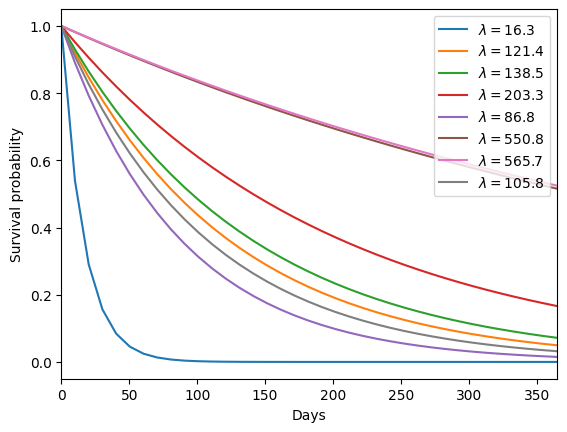

In [100]:
t = np.linspace(0, max(y_test[:,0]), 100)

S0 = sp.stats.expon.sf

for i in range(8):
    sample_lambda = lambda_det[i]
    y_true = y_test[i]
    color = 'blue' if y_true[1] == 1 else 'red'
    plt.plot(t, S0(t / sample_lambda), label = f"$\lambda={round(sample_lambda, 1)}$");
    
plt.ylabel("Survival probability")
plt.xlabel("Days")
# plt.title("Effect of $\kappa$")
plt.legend();
plt.xlim(0, 365);


In [101]:
t = np.linspace(0, max(y_train[:,0]), 100)
num_samples = X_test.shape[0]

t_samples = np.repeat(t, num_samples).reshape((len(t), -1))
median_surv = np.median(t_samples * S0(1 / lambda_det), axis=0)


In [102]:
c_index = lifelines.utils.concordance_index(y_test[:, 0], median_surv, 1-y_test[:, 1])
print(c_index)

0.6785714285714286


In [ ]:
0.6813

In [117]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df

,time,status,karno,diagtime,age,prior,trt,celltype
10,42,1,60,4,81,0,1,1
130,43,1,60,11,49,10,2,4
51,162,1,80,5,64,0,1,3
11,8,1,40,58,63,10,1,1
114,73,1,60,3,70,0,2,3
...,...,...,...,...,...,...,...,...
71,87,0,80,3,48,0,2,1
106,29,1,40,8,67,0,2,2
14,11,1,70,11,48,10,1,1
92,13,1,30,2,62,0,2,2


In [139]:
cph = lifelines.CoxPHFitter()
cph.fit(train_df, duration_col='time', event_col='status', formula="celltype + trt  ")

<lifelines.CoxPHFitter: fitted with 109 total observations, 8 right-censored observations>

In [140]:
cph.score(test_df, scoring_method="concordance_index")

0.4642857142857143